# Embedding People of Informatics

Here, embed individuals in different dimensions, as a form of dimensionality reduction. The following models were used to embed individuals:
1. tf-idf 
2. topic models 
    - topic model derived from metadata
    - topic model derived using documents in DBLP
    
    
## Methodology
1. Derive the models (for topic models, that is already derived in notebook on [topicModelling](topicModels/notebooks/topicModelling.ipynb).
2. Map individuals to the publications that they have published. (a bipartite graph between publications and individuals)
3. FOR each individual, using the publications derived, derive the embedding in the ***new*** space.
4. Calculate metrics such as **similarity** between individuals.

---

## Setup

In [2]:
import pandas as pd
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
import gensim.similarities as sim
import os
DATA_DIR = '../../data/data_schoolofinf/'

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Tokens from collection
lookup_combined_toks = pd.read_pickle(
    os.path.join(DATA_DIR, 'toks', 'toks.combined.pkl'))

In [5]:
# Filter the list of publications by:
# 1) Number of collaborators for that publication should be at least 2 (otherwise we wont see those authors in the collaboration graph anyway)
# lookup_pub = pd.read_pickle(os.path.join(DATA_DIR, 'lookup_pub.pkl'))
# lookup_pub['num_collab'] = lookup_pub['edges'].apply(lambda x: len(x))
# lookup_pub_atleast2 = lookup_pub.drop(
#     lookup_pub[(lookup_pub.num_collab < 2)].index)

# 2) year of publication
lookup_combined_toks.drop(
    lookup_combined_toks[(lookup_combined_toks.year < 1997)
                         | (lookup_combined_toks.year > 2017)].index,
    inplace=True)

In [6]:
# lookup_combined_toks_rest = lookup_combined_toks.drop(
#     lookup_pub_atleast2[lookup_pub_atleast2.num_collab < 2].index)

In [7]:
len(lookup_combined_toks)

8028

In [8]:
# Replace empty entries in lookup_combined_toks_rest.toks_pdf2txt with list []
lookup_combined_toks[
    'toks_pdf2txt'] = lookup_combined_toks.toks_pdf2txt.apply(
        lambda x: [] if not len(x) else x)
lookup_combined_toks[
    'toks_metada'] = lookup_combined_toks.toks_metada.apply(
        lambda x: [] if not len(x) else x)

Import mapping for individuals

In [9]:
# We are only interested in individuals in the collab graph:
poinf_ids = pd.read_csv(
    os.path.join(DATA_DIR, 'poinf_collabgraph_1997-017.txt'),
    sep='\n',
    names=['id'])

In [10]:
df_pubmapping = pd.read_pickle(
    os.path.join(DATA_DIR, 'poinf_to_pub_mapping.pkl'))

In [11]:
# merge the two dataframes, so that those that we are not interested are excluded:
df_pubmapping.set_index('id', inplace=True)
poinf_ids.set_index('id', inplace=True)
df_pubmapping_4_collabgraph = poinf_ids.join(df_pubmapping, how='left')

In [12]:
len(df_pubmapping_4_collabgraph)

194

# Simple embedding using TF-IDF

1. Create TF-IDF for each terms
2. Using the mapping for `poinf-> publications` created, create list of tokens for each indivudal
3. As in information retrieval, find individuals who have are most similar. This is done using `cosine similarity`

## `METADATA` ONLY

### import metadata corpus:

In [13]:
corpus_metadata = lookup_combined_toks.toks_metada.tolist()

In [14]:
len(corpus_metadata)

8028

In [15]:
# Create the TFIDF model using the dictionary trained on the corpus
dictionary_metada = Dictionary.load(
    os.path.join(DATA_DIR, 'corpora', 'dictionary.meta'))

In [16]:
tfidf_metada = TfidfModel(dictionary=dictionary_metada, normalize=True)
# tfidf_metada.save(os.path.join(DATA_DIR,'models','tfidf_metadata'))

In [17]:
test = corpus_metadata[0]
print(test)

['query', 'processing', 'data', 'integration', 'chapter', 'illustrate', 'main', 'technique', 'processing', 'query', 'data', 'integration', 'first', 'part', 'chapter', 'focus', 'problem', 'query', 'answering', 'relational', 'setting', 'describes', 'approach', 'based', 'variant', 'chase', 'along', 'deal', 'integrity', 'constraint', 'access', 'pattern', 'second', 'part', 'chapter', 'investigates', 'query', 'processing', 'context', 'semistructured', 'data', 'best', 'described', 'graph', 'based', 'data', 'model', 'expressiveness', 'query', 'language', 'common', 'traditional', 'database', 'system', 'allows', 'point', 'subtle', 'difference', 'query', 'answering', 'query', 'rewriting', 'chapter', 'closed', 'brief', 'discussion', 'query', 'processing', 'data', 'integration', 'xml', 'ontology', 'data', 'exchange', 'integration', 'stream', 'dagstuhl', 'germany', 'schloss', 'dagstuhl', 'leibniz', 'zentrum', 'fuer', 'informatik', 'germany', 'schloss', 'dagstuhl', 'leibniz', 'zentrum', 'fuer', 'info

In [18]:
corpus_bows = [dictionary_metada.doc2bow(doc) for doc in corpus_metadata]

### Generate tfidf scores for each individual:

In [25]:
_indices = set(lookup_combined_toks.index)
def gen_toks(pub_ids):
    """
    Take in a set of pub_ids and concatenate all the tokens together
    """
    pub_ids = pub_ids.intersection(_indices)
    _df = lookup_combined_toks.loc[list(pub_ids)]
    out = []
    for a in _df.toks_metada.tolist():
        out += a
    return out

In [26]:
df_pubmapping_4_collabgraph['toks'] = df_pubmapping_4_collabgraph[
    'pub_ids'].apply(gen_toks)

In [27]:
df_pubmapping_4_collabgraph.head(3)

,pub_ids,toks
id,,
dbb07214-3753-4bba-a630-e1857e7efb09,"{214f2863-aed3-412b-9414-3b6bc5319688, b8e235b...","[demonstration, paper, comparative, study, sur..."
2b36a690-b726-438e-8eb7-1128a7e7775d,"{80fa1756-cb6c-4b60-9e4a-b85a2f43f600, 6fa244f...","[topological, trajectory, classification, filt..."
666503f8-4508-4fd8-8645-18e0436423cf,"{d4f70944-eee3-4e68-88bc-477b1b11d1ef, c9a30e6...","[bayesian, model, diachronic, meaning, change,..."


In [28]:
df_pubmapping_4_collabgraph[
    'tfidf'] = df_pubmapping_4_collabgraph['toks'].apply(
        lambda x: tfidf_metada[dictionary_metada.doc2bow(x)] if len(x) else None
    )

In [29]:
df_pubmapping_4_collabgraph.info()

<class 'pandas.core.frame.DataFrame'>
Index: 194 entries, dbb07214-3753-4bba-a630-e1857e7efb09 to 5f66e548-1906-404b-a625-40a1bbbdce1e
Data columns (total 3 columns):
pub_ids    194 non-null object
toks       194 non-null object
tfidf      194 non-null object
dtypes: object(3)
memory usage: 11.1+ KB


### Create Matrix to lookup similarity

In [30]:
index = sim.Similarity(
    output_prefix='20yrs_metadata',
    corpus=df_pubmapping_4_collabgraph.tfidf.tolist(),
    num_features=len(dictionary_metada))

In [31]:
# index.save(os.path.join(DATA_DIR, 'models', 'index_20yrs_metadata'))

In [32]:
heatmap = []
for i in range(len(df_pubmapping_4_collabgraph)):
    heatmap.append(index[df_pubmapping_4_collabgraph.tfidf.iloc[i]])

### Visualise the similarities

In [33]:
heatmap = np.array(heatmap)

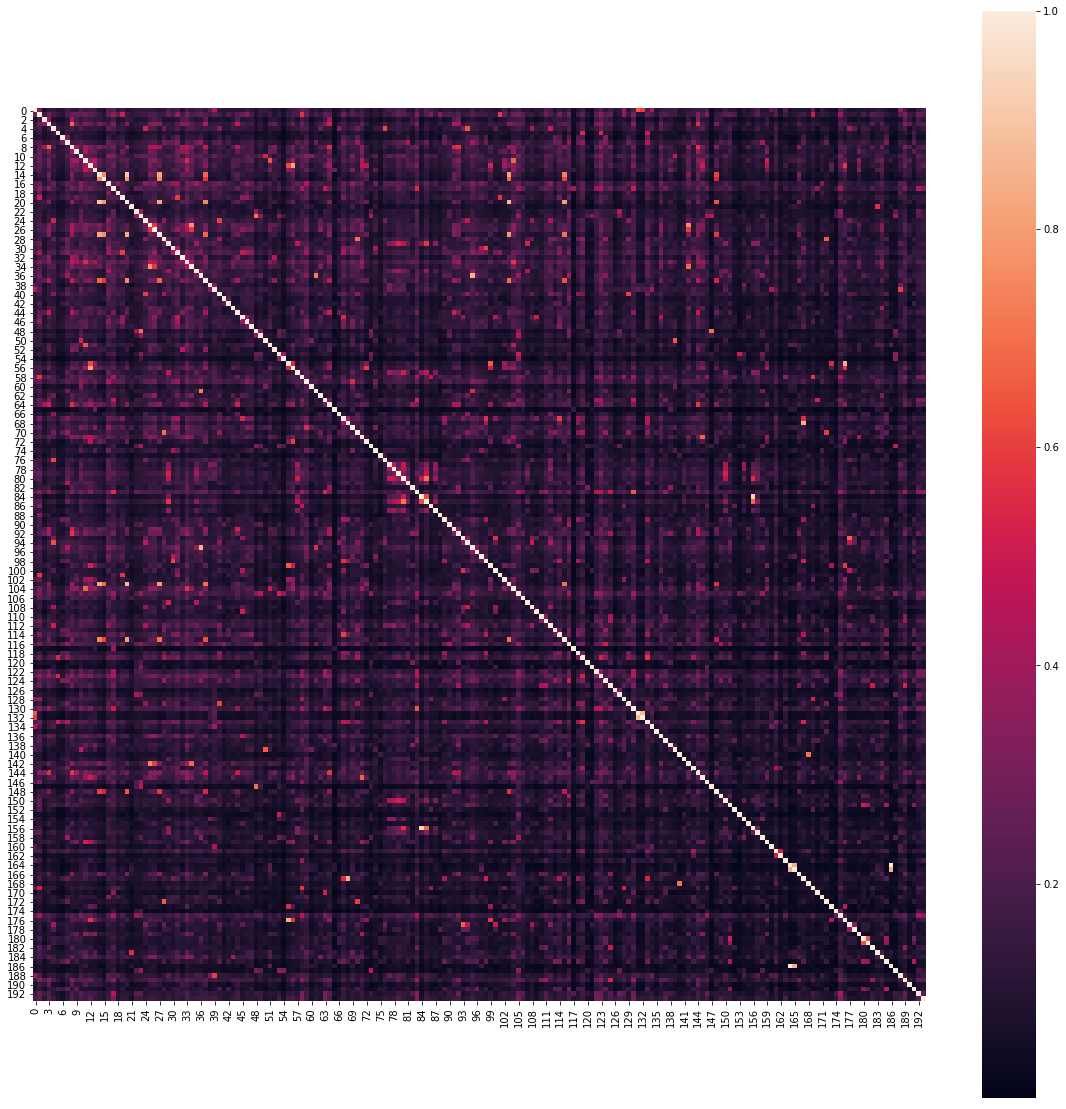

In [34]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
sns.heatmap(heatmap, ax=ax, square=True)

## `METADATA` + `pdf2txt` too:

### Create corpus

In [35]:
concat_toks = [
    a + b for a, b in zip(lookup_combined_toks.toks_metada.tolist(),
                          lookup_combined_toks.toks_pdf2txt.tolist())
]

In [36]:
len(concat_toks)

8028

In [37]:
dictionary_all = Dictionary.load(
    os.path.join(DATA_DIR, 'corpora', 'dictionary.all'))

In [38]:
tfidf_all = TfidfModel(dictionary=dictionary_all, normalize=True)
# tfidf_all.save(os.path.join(DATA_DIR,'models','tfidf_all'))

In [39]:
corpus_bows = [dictionary_all.doc2bow(doc) for doc in concat_toks]

### Generate tfidf score for each individual

In [42]:
_indices = set(lookup_combined_toks.index)

def gen_toks(pub_ids):
    """
    Take in a set of pub_ids and concatenate all the tokens together
    """
    pub_ids = pub_ids.intersection(_indices)
    _df = lookup_combined_toks.loc[list(pub_ids)]

    # Constraint to 1997-2017
    out = []
    for a,b in zip(_df.toks_metada.tolist(),_df.toks_pdf2txt.tolist()):
        out += a + b
    return out

In [43]:
df_pubmapping_4_collabgraph['toks'] = df_pubmapping_4_collabgraph[
    'pub_ids'].apply(gen_toks)

In [44]:
df_pubmapping_4_collabgraph[
    'tfidf'] = df_pubmapping_4_collabgraph['toks'].apply(
        lambda x: tfidf_all[dictionary_all.doc2bow(x)] if len(x) else None
    )

### Similarity Matrix

In [45]:
index = sim.Similarity(
    output_prefix='20yrs_metadata',
    corpus=df_pubmapping_4_collabgraph.tfidf.tolist(),
    num_features=len(dictionary_all))

In [46]:
index.save(os.path.join(DATA_DIR, 'models', 'index_20yrs_all'))

### Visualisation

In [47]:
heatmap = []
for i in range(len(df_pubmapping_4_collabgraph)):
    heatmap.append(index[df_pubmapping_4_collabgraph.tfidf.iloc[i]])

In [48]:
heatmap = np.array(heatmap)

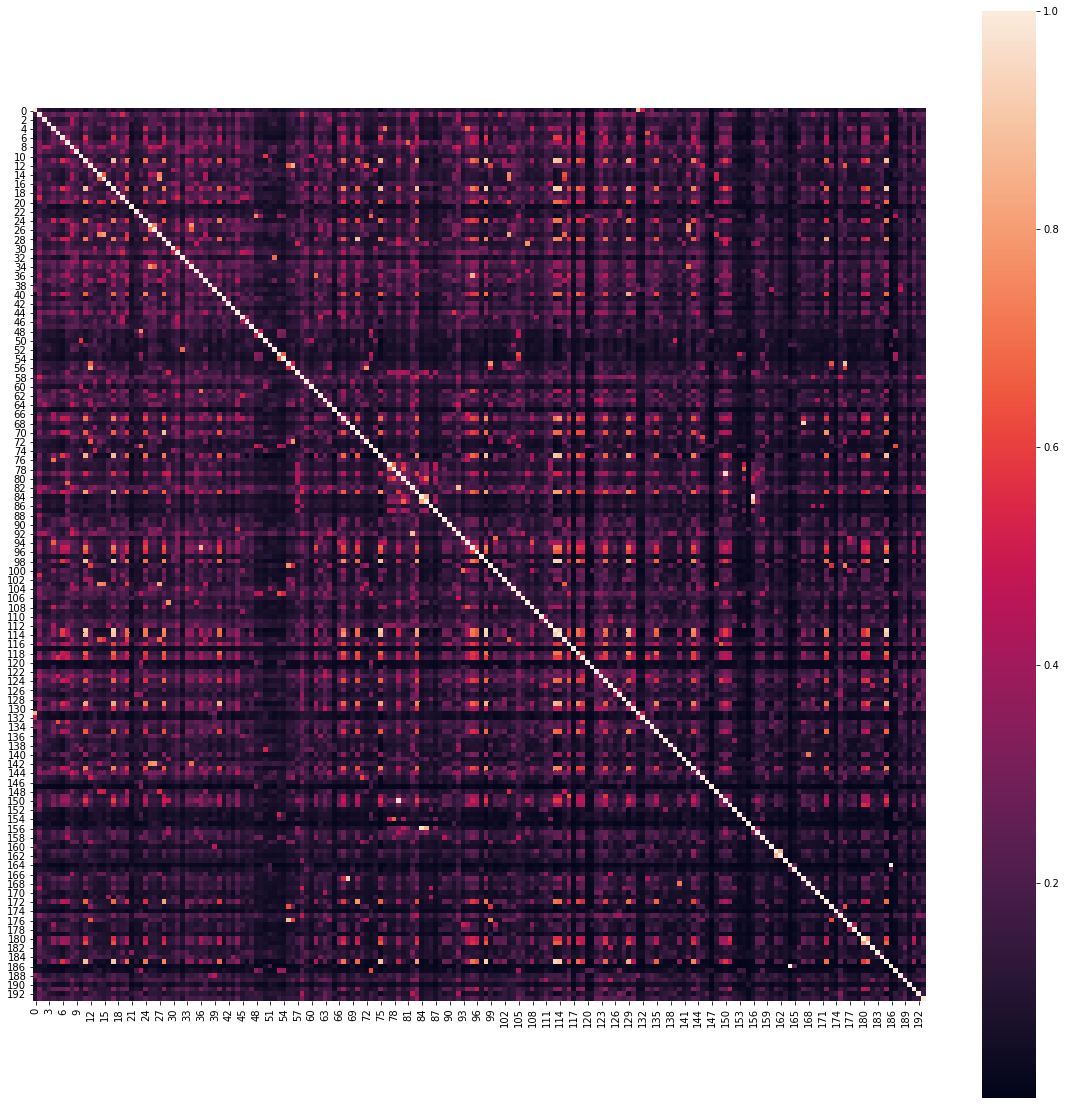

In [49]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
sns.heatmap(heatmap, ax=ax, square=True)

# Topic models

In [20]:
from gensim import models

## Model2 : metadata only (1997-2017)

In [13]:
tm_model2 = models.LdaModel.load(os.path.join(DATA_DIR, 'models', 'tm', 'tm_model2'))

In [15]:
dict_meta = Dictionary.load(os.path.join(DATA_DIR,'corpora','dictionary.meta'))

In [17]:
_indices = set(lookup_combined_toks.index)
def gen_toks(pub_ids):
    """
    Take in a set of pub_ids and concatenate all the tokens together
    """
    pub_ids = pub_ids.intersection(_indices)
    _df = lookup_combined_toks.loc[list(pub_ids)]
    out = []
    for a in _df.toks_metada.tolist():
        out += a
    return out

In [18]:
df_pubmapping_4_collabgraph['toks'] = df_pubmapping_4_collabgraph[
    'pub_ids'].apply(gen_toks)

In [24]:
tm_model2.minimum_probability = 0.01 # change the probabilty that we set to 0.01, instead of 0.9

In [26]:
df_pubmapping_4_collabgraph[
    'tm_model2'] = df_pubmapping_4_collabgraph['toks'].apply(
        lambda x: tm_model2.get_document_topics(dict_meta.doc2bow(x)) if len(x) else None
    )

In [37]:
index = sim.Similarity(
    output_prefix='topicmodel2',
    corpus=df_pubmapping_4_collabgraph.tm_model2.tolist(),
    num_features=tm_model2.num_topics
)

In [38]:
index.save(os.path.join(DATA_DIR, 'models', 'tm_model2_index'))

In [39]:
heatmap = []
for i in range(len(df_pubmapping_4_collabgraph)):
    heatmap.append(index[df_pubmapping_4_collabgraph.tm_model2.iloc[i]])

In [40]:
heatmap = np.array(heatmap)

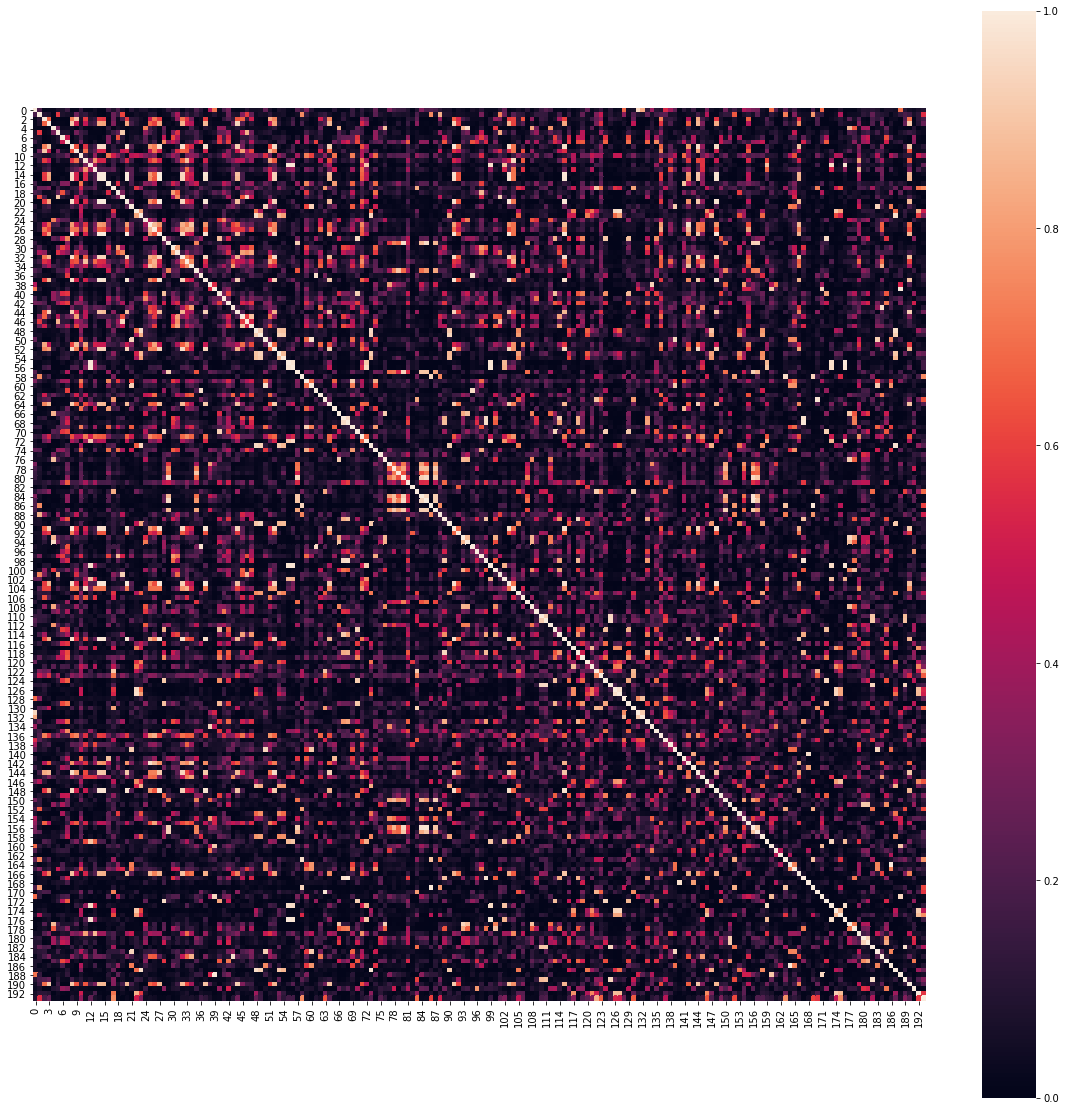

In [41]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
sns.heatmap(heatmap, ax=ax, square=True)

## DBLP topic model

In [13]:
DATA_DIR = '../../data/data_dblp/'

In [48]:
dict_dblp = Dictionary.load(os.path.join(DATA_DIR, 'corpora','dictionary.dblp.1997-2017_2'))

In [49]:
len(dict_dblp)

76471

In [50]:
tm_dblp = models.LdaModel.load(os.path.join(DATA_DIR,'models','tm','tm_dblp'))

In [51]:
_indices = set(lookup_combined_toks.index)
def gen_toks(pub_ids):
    """
    Take in a set of pub_ids and concatenate all the tokens together
    """
    pub_ids = pub_ids.intersection(_indices)
    _df = lookup_combined_toks.loc[list(pub_ids)]
    out = []
    for a in _df.toks_metada.tolist():
        out += a
    return out

In [52]:
df_pubmapping_4_collabgraph['toks'] = df_pubmapping_4_collabgraph[
    'pub_ids'].apply(gen_toks)

In [24]:
tm_dblp.minimum_probability = 0.01 # change the probabilty that we set to 0.01, instead of 0.9

In [53]:
len(tm_dblp.id2word)

76471

In [55]:
df_pubmapping_4_collabgraph[
    'tm_dblp'] = df_pubmapping_4_collabgraph['toks'].apply(
        lambda x: tm_dblp.get_document_topics(dict_dblp.doc2bow(x)) if len(x) else None
    )

In [56]:
index = sim.Similarity(
    output_prefix='topicmodel_dblp',
    corpus=df_pubmapping_4_collabgraph.tm_dblp.tolist(),
    num_features=tm_dblp.num_topics
)

In [57]:
index.save(os.path.join(DATA_DIR, 'models', 'tm_dblp_index'))

In [58]:
heatmap = []
for i in range(len(df_pubmapping_4_collabgraph)):
    heatmap.append(index[df_pubmapping_4_collabgraph.tm_dblp.iloc[i]])

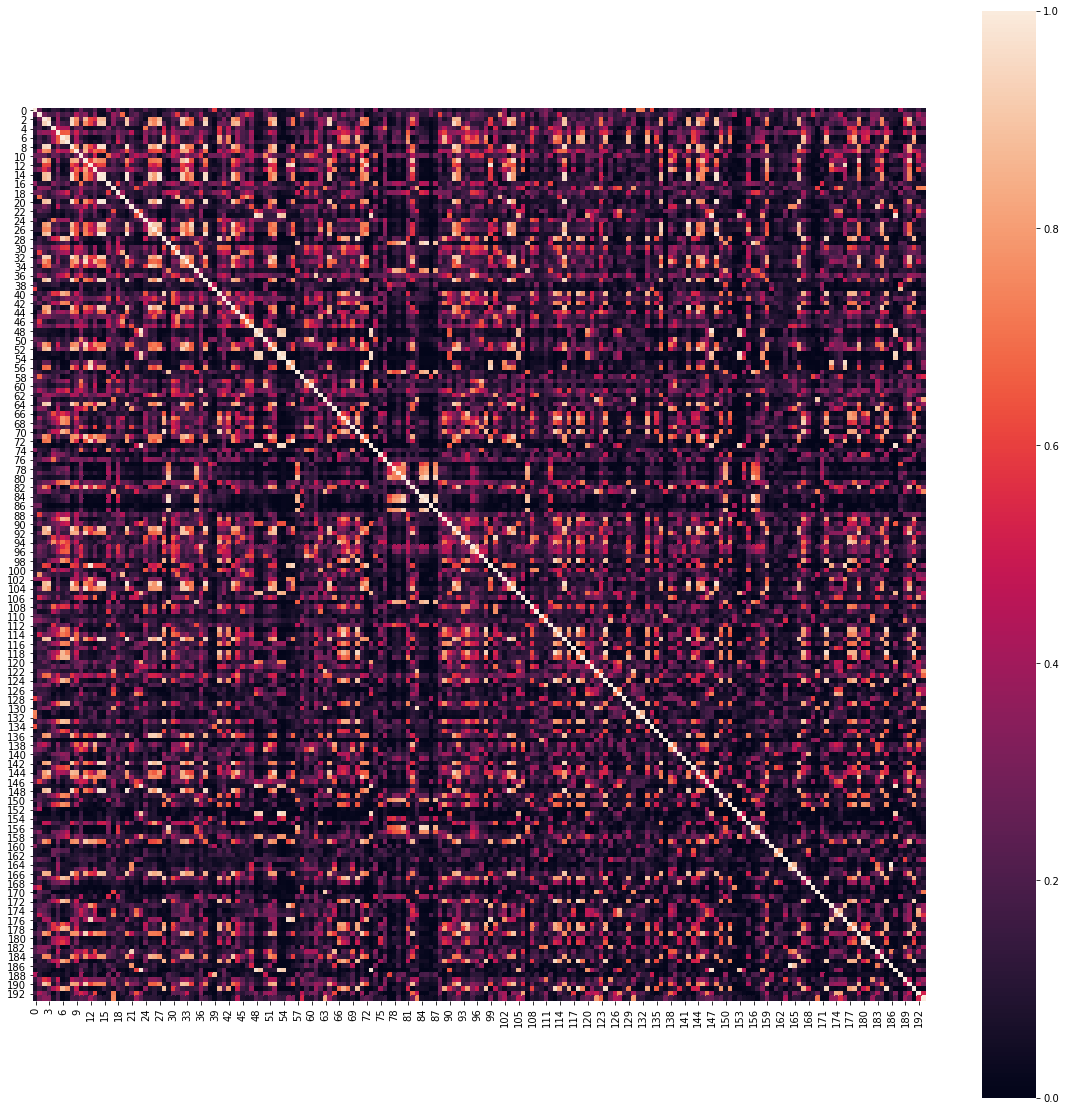

In [59]:
heatmap = np.array(heatmap)
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
sns.heatmap(heatmap, ax=ax, square=True)